### Hybrid Retriever - Combining Dense & Sparse Retriever

A Hybrid Retriever (also called an Ensemble Retriever) is a retrieval technique that combines both sparse and dense retrieval methods to improve the accuracy and relevance of search results in information retrieval systems or LLM-based applications.

It blends:

Sparse retrieval → uses keyword-based methods like BM25 or TF-IDF, which rely on exact word matching.

Dense retrieval → uses embedding-based similarity (e.g., FAISS with transformer embeddings), which captures semantic meaning.

In [1]:
from langchain_community.vectorstores import FAISS
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever
from langchain.schema import Document



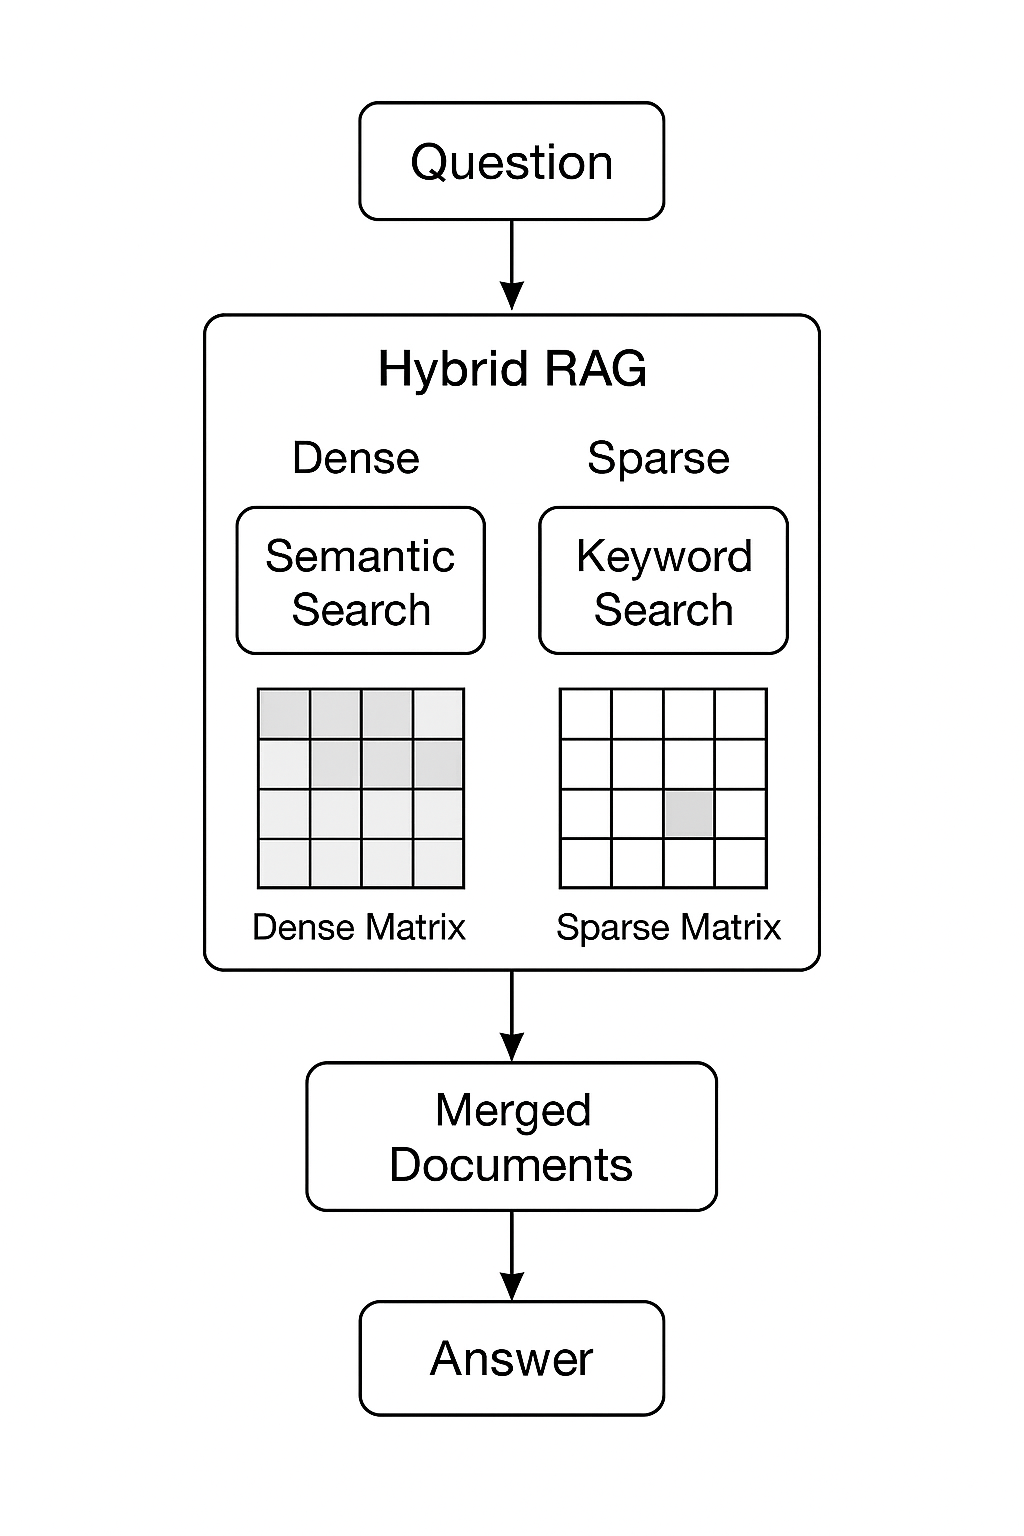

In [2]:
from IPython.display import Image
Image(filename=r"C:\Users\Akarshan Kapoor\Desktop\hybrid.png")

In [3]:
# sample documents

docs =[
    Document(page_content="The capital of France is Paris."),
    Document(page_content="Pinecone is a vector database for semantic search for LLM's applications."),
    Document(page_content="Langchain is a framework for developing applications powered by language models."),
    Document(page_content="Langchain can be used for a variety of tasks, including chatbots, document analysis, and agentic ai applications."),
    Document(page_content="The Eiffel Tower is in Paris.")
]


# Dense Retriever ( FAISS + HuggingFaceEmbeddings)

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
dense_vectorstore = FAISS.from_documents(docs, embeddings)
dense_retriever = dense_vectorstore.as_retriever()


In a hybrid RAG system:

- Dense retriever gives a semantic similarity score for each document.


- Sparse retriever gives a keyword match score (e.g., BM25 score).

To combine them, you usually compute a weighted sum:



HybridScore=α⋅DenseScore+β⋅SparseScore


α → weight for semantic/dense retrieval


β → weight for keyword/sparse retrieval

By changing 

α and β, you control the ratio of semantic vs keyword influence.

In [4]:
# Sparse Retriever ( BM25 )

sparse_retriever = BM25Retriever.from_documents(docs)
sparse_retriever.k=3 # top k documents to retrieve

# Hybrid Retriever ( Ensemble of Dense + Sparse )
hybrid_retriever = EnsembleRetriever(
    retrievers=[dense_retriever, sparse_retriever],
    weights=[0.9, 0.1]
)

In [5]:
# Query and get relevant documents
query = "How can I build an application using LLMs?"
results = hybrid_retriever.invoke(query)

# Print the results
for i, doc in enumerate(results):
    print(f"Document {i+1}: {doc.page_content}")

Document 1: Langchain is a framework for developing applications powered by language models.
Document 2: Langchain can be used for a variety of tasks, including chatbots, document analysis, and agentic ai applications.
Document 3: Pinecone is a vector database for semantic search for LLM's applications.
Document 4: The capital of France is Paris.
Document 5: The Eiffel Tower is in Paris.


### RAG pipeline with hybrid retriever

In [6]:
from langchain_groq import ChatGroq
from langchain.prompts import PromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.retrieval import create_retrieval_chain


import os
from dotenv import load_dotenv
load_dotenv()
# Access keys
groq_api_key = os.getenv("GROQ_AI_API")
hf_api_key = os.getenv("HUGGINGFACE_API_KEY")

In [7]:
# --- RAG with Hybrid Retriever ---

# Prompt Template
prompt_template = """
Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.

Context:
{context}

Question:
{input}

Answer:
"""
prompt = PromptTemplate.from_template(prompt_template)

# LLM
llm = ChatGroq(
    model="llama-3.1-8b-instant",
    api_key=groq_api_key,
    temperature=0.2
)

# Combine chain
stuff_chain = create_stuff_documents_chain(llm, prompt)

# RAG chain
rag_chain = create_retrieval_chain(
    retriever=hybrid_retriever,
    combine_docs_chain=stuff_chain
)

# --- TEST RAG CHAIN ---
query = "How can I build an application using LLMs?"
response = rag_chain.invoke({"input": query})   # response is a dict with 'answer' and 'context'

# --- PRINT OUTPUT ---
print("Response:", response["answer"])

print("\nSource Documents:")
for doc in response["context"]:
    print(f"- {doc.page_content}")


Response: To build an application using LLMs (Large Language Models), you can use the Langchain framework. Langchain provides a framework for developing applications powered by language models, allowing you to create a wide range of applications, including chatbots, document analysis, and agentic AI applications.

Source Documents:
- Langchain is a framework for developing applications powered by language models.
- Langchain can be used for a variety of tasks, including chatbots, document analysis, and agentic ai applications.
- Pinecone is a vector database for semantic search for LLM's applications.
- The capital of France is Paris.
- The Eiffel Tower is in Paris.


Why Hybrid Retrieval Helps

- RAG Pipelines: Prevents retrieval hallucination by ensuring both exact and fuzzy matches are considered.

- Technical Documentation Search: Developers may search "how to use API" while the doc says "API usage" — BM25 and semantic together improve hit rate.

- Legal/Medical QA: Some queries require precise term matching (BM25), while others need general understanding (dense).

- E-commerce/Product Search: "cheap noise-canceling headphones" could match "affordable ANC earbuds" — dense helps; BM25 confirms "ANC".

- Multilingual or Cross-lingual Retrieval: Semantic models can bridge language differences; BM25 ensures matching if terms are in the same language.

- Customer Support: Real users may type vague or keyword-heavy queries — hybrid improves retrieval reliability in chatbots/FAQs.

- Transcripts/Unstructured Data: Speech data or emails may contain inconsistent phrasing — dense retrieval picks meaning, sparse supports clarity.

### Hybrid Search Strategies


- Weighted Hybrid: Combine dense & sparse scores using weights (α for dense, 1–α for sparse).

- Re-ranking Hybrid: Use sparse search to get top candidates → re-rank with dense search.

- Sequential/Cascading: Try keyword search first, fall back to semantic if needed.

- Query Expansion: Expand query (synonyms/embeddings) → run both dense & sparse search.

- Multi-Vector: Use multiple embeddings (text + metadata) → combine results.